In [1]:
!pip install xgboost

In [2]:
import pandas as pd 
df = pd.read_csv('DASS.csv')
df

,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q3_1_S1,Q3_2_S2,Q3_3_S3,Q3_4_S4,...,Anxiety_Level,Q3_15_D1,Q3_16_D2,Q3_17_D3,Q3_18_D4,Q3_19_D5,Q3_20_D6,Q3_21_D7,Depression_Score,Depression_Level
0,21,2,0,4,4,1,3,3,3,3,...,3,0,3,3,2,3,3,3,17,5
1,18,2,0,4,4,1,3,3,3,3,...,2,0,2,3,0,0,2,0,7,3
2,40,2,1,2,1,1,3,3,1,2,...,5,2,1,1,2,2,1,2,11,4
3,24,1,0,4,2,0,3,3,1,2,...,5,2,1,1,2,2,1,2,11,4
4,50,1,1,2,2,0,3,3,3,2,...,2,1,0,0,1,2,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1807,52,2,1,2,1,0,0,0,0,0,...,5,2,3,0,1,2,0,0,8,3
1808,33,2,1,2,1,0,0,0,1,2,...,3,0,1,0,1,2,1,1,6,2
1809,24,2,1,2,1,0,0,0,1,1,...,1,0,0,0,1,0,0,0,1,1
1810,50,2,1,1,1,0,0,0,0,0,...,2,0,1,1,1,1,2,0,6,2


In [3]:
import os
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing & model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb

In [4]:
DATA_PATH = "DASS.csv"  # change if needed
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print(df.columns.tolist())


Dataset shape: (1812, 33)
['Q1_1', 'Q1_2', 'Q1_3', 'Q1_4', 'Q1_5', 'Q1_6', 'Q3_1_S1', 'Q3_2_S2', 'Q3_3_S3', 'Q3_4_S4', 'Q3_5_S5', 'Q3_6_S6', 'Q3_7_S7', 'Stress_Score', 'Stress_Level', 'Q3_8_A1', 'Q3_9_A2', 'Q3_10_A3', 'Q3_11_A4', 'Q3_12_A5', 'Q3_13_A6', 'Q3_14_A7', 'Anxiety_Score', 'Anxiety_Level', 'Q3_15_D1', 'Q3_16_D2', 'Q3_17_D3', 'Q3_18_D4', 'Q3_19_D5', 'Q3_20_D6', 'Q3_21_D7', 'Depression_Score', 'Depression_Level']


In [5]:
for col in ['Depression_Score','Anxiety_Score','Stress_Score','Depression_Level','Anxiety_Level','Stress_Level']:
    if col not in df.columns:
        raise ValueError(f"Expected column {col} in CSV but not found.")

# Normalize Age (Q1_1)
df['Age_Normalized'] = (df['Q1_1'] - df['Q1_1'].min()) / (df['Q1_1'].max() - df['Q1_1'].min())


In [6]:
df['Gender'] = df['Q1_2'].map({1: 'Male', 2: 'Female'})
df['Marital_Status'] = df['Q1_3'].map({0: 'No', 1: 'Yes'})
df['Education'] = df['Q1_4'].map({
    1: 'Illiterate', 2: 'Primary', 3: 'SSC', 4: 'HSC', 5: 'Graduation+'})
df['Occupation'] = df['Q1_5'].map({
    1: 'Housewife', 2: 'Service', 3: 'Business', 4: 'Student', 
    5: 'Day labor', 6: 'Unemployed'
})
df['Sleep_Problem'] = df['Q1_6'].map({0: 'No', 1: 'Yes'})


In [7]:
def get_status(row):
    if row['Stress_Level'] >= 3:
        return "Stressed"
    elif row['Anxiety_Level'] >= 3:
        return "Anxious"
    elif row['Depression_Level'] >= 3:
        return "Depressed"
    else:
        return "Normal"


In [8]:
df['Mental_Health_Status'] = df.apply(get_status, axis=1)
print("Status counts:\n", df['Mental_Health_Status'].value_counts())


Status counts:
 Mental_Health_Status
Normal       657
Stressed     596
Anxious      375
Depressed    184
Name: count, dtype: int64


In [9]:
q_items = [
    'Q3_1_S1','Q3_2_S2','Q3_3_S3','Q3_4_S4','Q3_5_S5','Q3_6_S6','Q3_7_S7',
    'Q3_8_A1','Q3_9_A2','Q3_10_A3','Q3_11_A4','Q3_12_A5','Q3_13_A6','Q3_14_A7',
    'Q3_15_D1','Q3_16_D2','Q3_17_D3','Q3_18_D4','Q3_19_D5','Q3_20_D6','Q3_21_D7'
]

features = ['Age_Normalized', 'Q1_1'] + q_items + ['Gender','Marital_Status','Education','Occupation','Sleep_Problem']
# ensure columns exist
for c in features:
    if c not in df.columns:
        raise ValueError(f"Feature {c} not in dataset")


In [10]:
from sklearn.preprocessing import LabelEncoder
X = df[features].copy()
y = df['Mental_Health_Status'].copy()

# -------------------------
# 5) Train/test split (stratify)
# -------------------------


# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)   # Now y_encoded = [0,1,2,3] instead of strings

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.20, stratify=y_encoded, random_state=42
)
print(y_train)

[2 0 2 ... 3 0 3]


In [11]:
numeric_features = ['Age_Normalized','Q1_1'] + q_items
categorical_features = ['Gender','Marital_Status','Education','Occupation','Sleep_Problem']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [12]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop'
)

In [13]:
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', xgb_clf)
])

In [14]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.1, 0.05]
}

grid = GridSearchCV(
    pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1
)


In [15]:

print("Starting Grid Search ...")
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_model = grid.best_estimator_


Starting Grid Search ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\Hp\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [21:29:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Best CV score: 0.935127674258109


In [16]:
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.9614

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        75
           1       1.00      0.89      0.94        37
           2       0.96      0.97      0.96       132
           3       0.98      0.99      0.98       119

    accuracy                           0.96       363
   macro avg       0.97      0.95      0.96       363
weighted avg       0.96      0.96      0.96       363



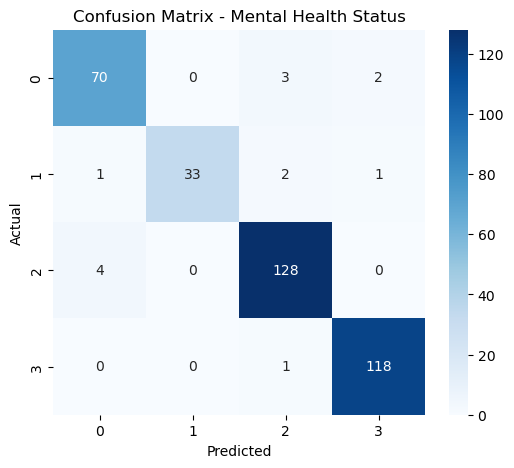

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.named_steps['clf'].classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.named_steps['clf'].classes_,
            yticklabels=best_model.named_steps['clf'].classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Mental Health Status")
plt.show()


In [18]:
DEPRESSION_CUTOFFS = [
    (0, 4, 'Normal'),
    (5, 6, 'Mild'),
    (7, 10, 'Moderate'),
    (11, 13, 'Severe'),
    (14, 21, 'Extremely Severe')
]

ANXIETY_CUTOFFS = [
    (0, 3, 'Normal'),
    (4, 5, 'Mild'),
    (6, 7, 'Moderate'),
    (8, 9, 'Severe'),
    (10, 21, 'Extremely Severe')
]

STRESS_CUTOFFS = [
    (0, 7, 'Normal'),
    (8, 9, 'Mild'),
    (10, 12, 'Moderate'),
    (13, 16, 'Severe'),
    (17, 21, 'Extremely Severe')
]

In [19]:
def map_severity(score, cutoffs):
    for lo, hi, label in cutoffs:
        if lo <= score <= hi:
            return label
    return 'Unknown'

def get_pred_with_severity(sample_df, model):
    """
    Input: single-row DataFrame (same columns as features)
    Output: (status_string, severity_string or None)
    """
    pred_status = model.predict(sample_df)[0]
    # If normal -> severity None
    if pred_status == 'Normal':
        return pred_status, None
    # If predicted 'Depressed' -> map depression score
    if pred_status == 'Depressed':
        score = int(sample_df.index.map(lambda i: df.loc[i,'Depression_Score']).values[0]) if 'Depression_Score' not in sample_df.columns else int(sample_df['Depression_Score'].iloc[0])
        sev = map_severity(score, DEPRESSION_CUTOFFS)
        return pred_status, sev
    if pred_status == 'Anxious':
        score = int(sample_df.index.map(lambda i: df.loc[i,'Anxiety_Score']).values[0]) if 'Anxiety_Score' not in sample_df.columns else int(sample_df['Anxiety_Score'].iloc[0])
        sev = map_severity(score, ANXIETY_CUTOFFS)
        return pred_status, sev
    if pred_status == 'Stressed':
        score = int(sample_df.index.map(lambda i: df.loc[i,'Stress_Score']).values[0]) if 'Stress_Score' not in sample_df.columns else int(sample_df['Stress_Score'].iloc[0])
        sev = map_severity(score, STRESS_CUTOFFS)
        return pred_status, sev
    return pred_status, None


In [20]:
X_test_reset = X_test.copy()
X_test_reset = X_test_reset.reset_index()  # keep original index to find scores in df
X_test_reset.set_index('index', inplace=True)

print("\nSample predictions with severity (first 10):")
for idx in X_test_reset.index[:10]:
    sample = X_test_reset.loc[[idx]]  # keep as dataframe
    status, severity = get_pred_with_severity(sample, best_model)
    print(f"Index {idx} --> Predicted: {status}; Severity: {severity}")



Sample predictions with severity (first 10):
Index 1718 --> Predicted: 2; Severity: None
Index 840 --> Predicted: 1; Severity: None
Index 972 --> Predicted: 2; Severity: None
Index 1686 --> Predicted: 2; Severity: None
Index 754 --> Predicted: 3; Severity: None
Index 1459 --> Predicted: 3; Severity: None
Index 1224 --> Predicted: 2; Severity: None
Index 890 --> Predicted: 2; Severity: None
Index 288 --> Predicted: 3; Severity: None
Index 751 --> Predicted: 3; Severity: None


In [21]:
import joblib

# Save best model and label encoder
joblib.dump(best_model, "dass_xgb_pipeline.joblib")
joblib.dump(le, "label_encoder.joblib")

print("Model and Label Encoder saved successfully!")


Model and Label Encoder saved successfully!
